### Description:
    This script demonstrates a naive active learning loop for sentiment analysis on the SST-2 dataset.
    Instead of sophisticated sampling methods (like uncertainty sampling or query-by-committee),
    we use a random (naive) selection of new samples to add to our training set in each iteration.
    The model is fine-tuned on the current labeled data and then evaluated on the validation set.
    Finally, the script plots the validation accuracy vs. the number of labeled samples.

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt

c:\python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
model_name = "distilbert-base-uncased"  # Base model; we will fine-tune it for SST-2
num_labels = 2

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the chosen device

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [6]:
train_dataset = load_dataset("glue", "sst2", split="train")
val_dataset = load_dataset("glue", "sst2", split="validation")

In [7]:
def collate_fn(batch):
    texts = [item["sentence"] for item in batch]         # Extract the sentences from the batch
    labels = [item["label"] for item in batch]             # Extract the corresponding labels
    tokenized_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    tokenized_inputs["labels"] = torch.tensor(labels)      # Add labels as a tensor
    return tokenized_inputs

### Active Learning 

In [8]:
initial_label_size = 50      
acquisition_size = 50        
max_iterations = 10        

In [9]:
all_indices = list(range(len(train_dataset)))
random.shuffle(all_indices)

In [10]:
labeled_indices = all_indices[:initial_label_size]         
unlabeled_indices = all_indices[initial_label_size:]         

In [11]:
labeled_sizes = []
val_accuracies = []

#### Active Learning Loop

In [12]:
for iteration in range(max_iterations):
    print(f"\n=== Active Learning Iteration {iteration+1} ===")
    
    labeled_subset = Subset(train_dataset, labeled_indices)
    labeled_loader = DataLoader(labeled_subset, batch_size=16, shuffle=True, collate_fn=collate_fn)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    model.train()  
    epochs = 5
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(labeled_loader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()  
            input_ids = batch["input_ids"].to(device)        
            attention_mask = batch["attention_mask"].to(device)  
            labels = batch["labels"].to(device)                
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()          # Backpropagate 
            optimizer.step()         # Update model parameters
            epoch_loss += loss.item()  
        print(f"Epoch {epoch+1} Loss: {epoch_loss/len(labeled_loader):.4f}")

    
    val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
    model.eval()  
    all_preds = []
    all_labels = []
    with torch.no_grad():  
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits  
            preds = torch.argmax(logits, dim=-1)  
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Validation Accuracy: {accuracy*100:.2f}%")

    labeled_sizes.append(len(labeled_indices))
    val_accuracies.append(accuracy)
    
    # If the unlabeled pool is empty, stop the active learning loop
    if len(unlabeled_indices) == 0:
        break

    acquisition_count = min(acquisition_size, len(unlabeled_indices))
    new_indices = random.sample(unlabeled_indices, acquisition_count)
    labeled_indices.extend(new_indices)  
    unlabeled_indices = list(set(unlabeled_indices) - set(new_indices))
    
    print(f"Total labeled samples after acquisition: {len(labeled_indices)}")


=== Active Learning Iteration 1 ===


c:\python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 1 Loss: 0.7038


Training Epoch 2: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 2 Loss: 0.7091


Training Epoch 3: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch 3 Loss: 0.6287


Training Epoch 4: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 4 Loss: 0.6260


Training Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]


Epoch 5 Loss: 0.6080


Evaluating: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]


Validation Accuracy: 50.92%
Total labeled samples after acquisition: 100

=== Active Learning Iteration 2 ===


Training Epoch 1: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


Epoch 1 Loss: 0.6215


Training Epoch 2: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Epoch 2 Loss: 0.5591


Training Epoch 3: 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Epoch 3 Loss: 0.4590


Training Epoch 4: 100%|██████████| 7/7 [00:11<00:00,  1.57s/it]


Epoch 4 Loss: 0.3846


Training Epoch 5: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


Epoch 5 Loss: 0.2721


Evaluating: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


Validation Accuracy: 66.40%
Total labeled samples after acquisition: 150

=== Active Learning Iteration 3 ===


Training Epoch 1: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch 1 Loss: 0.3729


Training Epoch 2: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


Epoch 2 Loss: 0.2356


Training Epoch 3: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Epoch 3 Loss: 0.1332


Training Epoch 4: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


Epoch 4 Loss: 0.0722


Training Epoch 5: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch 5 Loss: 0.0366


Evaluating: 100%|██████████| 28/28 [00:25<00:00,  1.08it/s]


Validation Accuracy: 78.90%
Total labeled samples after acquisition: 200

=== Active Learning Iteration 4 ===


Training Epoch 1: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it]


Epoch 1 Loss: 0.1546


Training Epoch 2: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


Epoch 2 Loss: 0.0638


Training Epoch 3: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


Epoch 3 Loss: 0.0247


Training Epoch 4: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


Epoch 4 Loss: 0.0130


Training Epoch 5: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


Epoch 5 Loss: 0.0085


Evaluating: 100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Validation Accuracy: 79.47%
Total labeled samples after acquisition: 250

=== Active Learning Iteration 5 ===


Training Epoch 1: 100%|██████████| 16/16 [00:26<00:00,  1.63s/it]


Epoch 1 Loss: 0.1401


Training Epoch 2: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 2 Loss: 0.0504


Training Epoch 3: 100%|██████████| 16/16 [00:32<00:00,  2.06s/it]


Epoch 3 Loss: 0.0200


Training Epoch 4: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


Epoch 4 Loss: 0.0076


Training Epoch 5: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


Epoch 5 Loss: 0.0054


Evaluating: 100%|██████████| 28/28 [00:27<00:00,  1.02it/s]


Validation Accuracy: 81.31%
Total labeled samples after acquisition: 300

=== Active Learning Iteration 6 ===


Training Epoch 1: 100%|██████████| 19/19 [00:32<00:00,  1.73s/it]


Epoch 1 Loss: 0.1283


Training Epoch 2: 100%|██████████| 19/19 [00:30<00:00,  1.62s/it]


Epoch 2 Loss: 0.0302


Training Epoch 3: 100%|██████████| 19/19 [00:30<00:00,  1.61s/it]


Epoch 3 Loss: 0.0084


Training Epoch 4: 100%|██████████| 19/19 [00:30<00:00,  1.63s/it]


Epoch 4 Loss: 0.0046


Training Epoch 5: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]


Epoch 5 Loss: 0.0032


Evaluating: 100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


Validation Accuracy: 80.85%
Total labeled samples after acquisition: 350

=== Active Learning Iteration 7 ===


Training Epoch 1: 100%|██████████| 22/22 [00:38<00:00,  1.74s/it]


Epoch 1 Loss: 0.0925


Training Epoch 2: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]


Epoch 2 Loss: 0.0136


Training Epoch 3: 100%|██████████| 22/22 [00:36<00:00,  1.66s/it]


Epoch 3 Loss: 0.0300


Training Epoch 4: 100%|██████████| 22/22 [00:38<00:00,  1.76s/it]


Epoch 4 Loss: 0.0107


Training Epoch 5: 100%|██████████| 22/22 [00:36<00:00,  1.65s/it]


Epoch 5 Loss: 0.0025


Evaluating: 100%|██████████| 28/28 [00:38<00:00,  1.37s/it]


Validation Accuracy: 80.62%
Total labeled samples after acquisition: 400

=== Active Learning Iteration 8 ===


Training Epoch 1: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it]


Epoch 1 Loss: 0.0531


Training Epoch 2: 100%|██████████| 25/25 [01:27<00:00,  3.49s/it]


Epoch 2 Loss: 0.0160


Training Epoch 3: 100%|██████████| 25/25 [01:45<00:00,  4.23s/it]


Epoch 3 Loss: 0.0125


Training Epoch 4: 100%|██████████| 25/25 [01:55<00:00,  4.63s/it]


Epoch 4 Loss: 0.0062


Training Epoch 5: 100%|██████████| 25/25 [02:07<00:00,  5.08s/it]


Epoch 5 Loss: 0.0022


Evaluating: 100%|██████████| 28/28 [01:01<00:00,  2.18s/it]


Validation Accuracy: 80.62%
Total labeled samples after acquisition: 450

=== Active Learning Iteration 9 ===


Training Epoch 1: 100%|██████████| 29/29 [01:59<00:00,  4.13s/it]


Epoch 1 Loss: 0.1167


Training Epoch 2: 100%|██████████| 29/29 [01:57<00:00,  4.07s/it]


Epoch 2 Loss: 0.0247


Training Epoch 3: 100%|██████████| 29/29 [02:05<00:00,  4.34s/it]


Epoch 3 Loss: 0.0146


Training Epoch 4: 100%|██████████| 29/29 [02:20<00:00,  4.85s/it]


Epoch 4 Loss: 0.0049


Training Epoch 5: 100%|██████████| 29/29 [02:15<00:00,  4.68s/it]


Epoch 5 Loss: 0.0065


Evaluating: 100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


Validation Accuracy: 79.93%
Total labeled samples after acquisition: 500

=== Active Learning Iteration 10 ===


Training Epoch 1: 100%|██████████| 32/32 [02:24<00:00,  4.52s/it]


Epoch 1 Loss: 0.1050


Training Epoch 2: 100%|██████████| 32/32 [02:04<00:00,  3.89s/it]


Epoch 2 Loss: 0.0318


Training Epoch 3: 100%|██████████| 32/32 [02:14<00:00,  4.20s/it]


Epoch 3 Loss: 0.0057


Training Epoch 4: 100%|██████████| 32/32 [02:13<00:00,  4.18s/it]


Epoch 4 Loss: 0.0025


Training Epoch 5: 100%|██████████| 32/32 [02:58<00:00,  5.58s/it]


Epoch 5 Loss: 0.0024


Evaluating: 100%|██████████| 28/28 [01:04<00:00,  2.30s/it]

Validation Accuracy: 80.39%
Total labeled samples after acquisition: 550


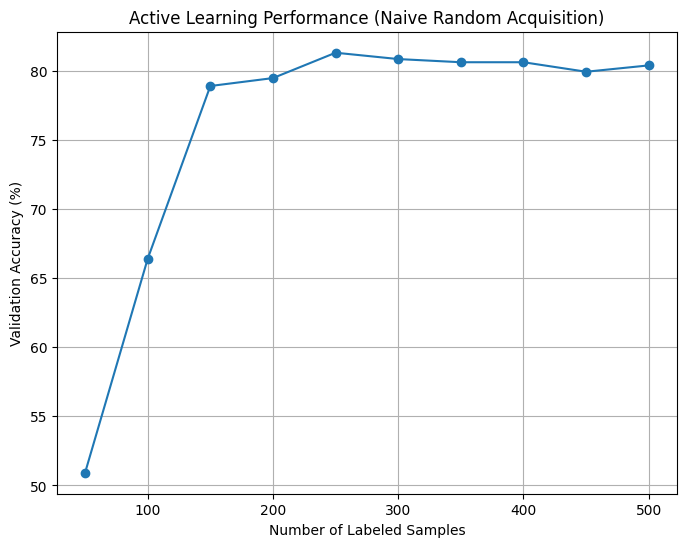

In [13]:
# Plot validation accuracy vs. number of labeled samples acquired
plt.figure(figsize=(8,6))
plt.plot(labeled_sizes, [acc*100 for acc in val_accuracies], marker='o', linestyle='-')
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Validation Accuracy (%)")
plt.title("Active Learning Performance (Naive Random Acquisition)")
plt.grid(True)
plt.show()